# Scenario 1: Data summarization

1. Train model (M1) on the complete dataset (D1)

2. Generate a summarization dataset using some technique (D2)

3. Train a new model (M2) on D2
    1. Use the same best hyperparameters as for M1   
    2. **Identify a new set of best hyperparameters**
    
4. Compare M1 and M2
    1. Evaluation M1 and M2 on the complete dataset D1.
    2. Evaluate M1 and M2 on a grid and compute divergence
    3. Compare feature importance vectors for individual data points from M1 and M2 (should be very similar)
    4. Compare errors on the test dataset (D3)

**Notes:**
- We assume that generation of a summarization dataset is implemented. It can be written in Python for prototyping.
- 4 can be done with an inference pipeline and eland
- We need a simple way to query a model using inference pipeline (e.g. Python wrapper?)
- Evaluations can also be done with sklearn?
- What is the minimum amount of data we can get away with?


In [66]:
%config Completer.use_jedi = False
import subprocess
import json
import tempfile
import pprint
import platform
import time
import string
import random

import pandas as pd
import numpy as np
import diversipy
import libtmux 

from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error


# I assume, your host OS is not CentOS
cloud = (platform.system() == 'Linux') and (platform.dist()[0] == 'centos')
if cloud:
    mlcpp_root = '/ml-cpp'
else:
    import os
    mlcpp_root = os.environ['CPP_SRC_HOME']+'/build/distribution/platform/linux-x86_64'
dfa_path = mlcpp_root+'/bin/data_frame_analyzer'

server = libtmux.Server()

ImportError: cannot import name 'HTML'

In [55]:
def get_predictions(results):
    predictions = []
    for item in results:
        if 'row_results' in item:
            predictions.append(item['row_results']['results']['ml']['54_prediction'])
    return np.array(predictions)

In [56]:
def get_hyperparameters(results):
    hyperparameters = {}
    for item in results:
        if 'model_metadata' in item:
            for hyperparameter in item['model_metadata']['hyperparameters']:
                hyperparameters[hyperparameter['name']] = hyperparameter['value']
    return hyperparameters

In [46]:
def run_job(input, config, persist=None, restore=None):
    output = tempfile.NamedTemporaryFile(mode='wt')
    job_suffix = ''.join(random.choices(string.ascii_lowercase, k=5))
    job_name = 'job_{}'.format(job_suffix)
    cmd = [dfa_path,
    "--input", input,
    "--config", config,
    "--output", output.name]
    
    
    if persist:
        cmd += ["--persist", persist]
    if restore:
        cmd += ['--restore', restore]
 
    cmd = ' '.join(cmd)
    
    session = server.new_session(job_name)
    window = session.new_window(attach=False)
    pane = window.split_window(attach=False)
    
    print("session: {}\tcommand:\n{}".format(session.get('session_name'), cmd))
    pane.send_keys(cmd)
    return {'name': job_name, 'pane': pane, 'output': output}

In [96]:
def wait_job_complete(job):
    pane = job['pane']
    output = job['output']
    while True :
        display.clear_output(wait=True)
        err = "\n".join(pane.capture_pane())
        out =  !grep "phase_progress" $output.name | tail -n10 
        out = "\n".join(out)
        display.display_html(display.HTML("""<table><tr>
                                                    <td width="50%" style="text-align:center;"><b>stderr</b></td>
                                                    <td width="50%" style="text-align:center;"><b>output</b></td>
                                                    </tr>
                                                    <tr>
                                                    <td width="50%" style="text-align:left;"><pre>{}</pre></td>
                                                    <td width="50%" style="text-align:left;"><pre>{}</pre></td>
                                                    </tr>
                                            </table>"""
                                 .format(err, out)))
        if sum(['ML data frame analyzer exiting' in line for line in pane.capture_pane()[-5:]]) == 1:
            break
        time.sleep(5.0)
    with open(output.name) as fp:
        results = json.load(fp)
    # clean up
    output.close()
    server.kill_session(target_session=job['name'])
    return results

## 1. Train model (M1) on the complete dataset (D1)

In [94]:
job = run_job(input="datasets/facebook_6000.csv", 
              config="configs/facebook_6000.json",
              persist="model1.json")

session: job_wvekf	command:
/home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input datasets/facebook_6000.csv --config configs/facebook_6000.json --output /tmp/tmpvi9vq41z --persist model1.json


In [97]:
results = wait_job_complete(job)

stderr,output
"/home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input datasets/facebook_6000.csv --config configs/facebook_6000.json --output /tmp/tmpvi9vq41z --persist model1.json (env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter [jupyter-docker L|✚ 3…5⚑ 3] 14:31 $ /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input datasets/facebook_6000.csv --config configs/facebook_6000.json --output /tmp/tmpvi9vq41z --persist model1.json 2021-02-18 13:31:16,442755 UTC [6868] DEBUG Main.cc@141 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV 2021-02-18 13:31:16,442802 UTC [6868] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj 2021-02-18 13:31:16,442813 UTC [6868] DEBUG CSystemCallFilter_Linux.cc@127 Seccomp BPF filters available 2021-02-18 13:31:16,443877 UTC [6868] DEBUG CSystemCallFilter_Linux.cc@153 Seccomp BPF installed 2021-02-18 13:31:16,474712 UTC [6868] DEBUG CDataFrameAnalyzer.cc@104 Received 6000 rows 2021-02-18 13:33:09,811145 UTC [6868] WARN CBoostedTreeImpl.cc@245 Hyperparameter selection failed: exiting loop early 2021-02-18 13:33:11,209437 UTC [6868] INFO Main.cc@241 [{""name"":""E_DFTPMEstimatedPeakMemoryUsage"",""description"":""The upfront estimate of the peak memory training the predictive model would use"",""value"":44908909} ,{""name"":""E_DFTPMPeakMemoryUsage"",""description"":""The peak memory training the predictive model used"",""value"":44071048} ,{""name"":""E_DFTPMTimeToTrain"",""description"":""The time it took to train the predictive model"",""value"":113780} ,{""name"":""E_DFTPMTrainedForestNumberTrees"",""description"":""The total number of trees in the trained forest"",""value"":65} ] 2021-02-18 13:33:11,209524 UTC [6868] DEBUG Main.cc@246 ML data frame analyzer exiting (env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter [jupyter-docker L|✚ 3…5⚑ 3] 14:33 $",",{""phase_progress"":{""phase"":""fine_tuning_parameters"",""progress_percent"":31}} ,{""phase_progress"":{""phase"":""fine_tuning_parameters"",""progress_percent"":32}} ,{""phase_progress"":{""phase"":""fine_tuning_parameters"",""progress_percent"":33}} ,{""phase_progress"":{""phase"":""fine_tuning_parameters"",""progress_percent"":34}} ,{""phase_progress"":{""phase"":""fine_tuning_parameters"",""progress_percent"":39}} ,{""phase_progress"":{""phase"":""fine_tuning_parameters"",""progress_percent"":41}} ,{""phase_progress"":{""phase"":""fine_tuning_parameters"",""progress_percent"":100}} ,{""phase_progress"":{""phase"":""final_training"",""progress_percent"":75}} ,{""phase_progress"":{""phase"":""final_training"",""progress_percent"":100}} ,{""phase_progress"":{""phase"":""final_training"",""progress_percent"":100}}"


In [7]:
# keep only the last checkpoint with the final model
!echo "$(tail -n 3 model1.json)" > model1.json

/bin/bash: warning: command substitution: ignored null byte in input


## 2. Generate a sumarization dataset

In [8]:
dataset = pd.read_csv('datasets/facebook_6000.csv')
summarization = diversipy.subset.psa_select(dataset.to_numpy(), 1000)
summarization_df = pd.DataFrame(data=summarization, columns=dataset.columns)

In [9]:
# update config with the new number of rows
with open('configs/facebook_6000.json') as f:
    config = json.load(f)
config['rows'] = summarization_df.shape[0]

## 3. A. Train a new model with the same best best hyperparameters

In [10]:
hyperparameters = get_hyperparameters(results)
config['analysis']['parameters'] = { **config['analysis']['parameters'], **hyperparameters}

with tempfile.NamedTemporaryFile(mode='wt') as fconfig, tempfile.NamedTemporaryFile(mode='wt') as fdata:
    json.dump(config, fconfig)
    fconfig.file.close()
    summarization_df.to_csv(fdata, index=False)
    fdata.file.close()
    process = subprocess.run([
    dfa_path,
    "--input",
    fdata.name,
    "--config",
    fconfig.name, 
    "--persist",
    "model2.json"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print(process.stderr)

2021-02-17 12:45:19,956853 UTC [21194] DEBUG Main.cc@141 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV
2021-02-17 12:45:19,956898 UTC [21194] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj
2021-02-17 12:45:19,956907 UTC [21194] DEBUG CSystemCallFilter_Linux.cc@127 Seccomp BPF filters available
2021-02-17 12:45:19,957372 UTC [21194] DEBUG CSystemCallFilter_Linux.cc@153 Seccomp BPF installed
2021-02-17 12:45:19,957803 UTC [21194] WARN  CBoostedTreeFactory.cc@1205 Minimum tree depth must be at least two
2021-02-17 12:45:19,963865 UTC [21194] DEBUG CDataFrameAnalyzer.cc@104 Received 1000 rows
2021-02-17 12:45:35,311560 UTC [21194] WARN  CBoostedTreeImpl.cc@245 Hyperparameter selection failed: exiting loop early
2021-02-17 12:45:36,352135 UTC [21194] INFO  Main.cc@241 [{"name":"E_DFTPMEstimatedPeakMemoryUsage","description":"The upfront estim

In [11]:
# keep only the last checkpoint with the final model
!echo "$(tail -n 3 model2.json)" > model2.json

/bin/bash: warning: command substitution: ignored null byte in input


## 3. B. Train a new model with new best hyperparameters

In [12]:
with tempfile.NamedTemporaryFile(mode='wt') as fconfig, tempfile.NamedTemporaryFile(mode='wt') as fdata:
    json.dump(config, fconfig)
    fconfig.file.close()
    summarization_df.to_csv(fdata, index=False)
    fdata.file.close()
    process = subprocess.run([
    dfa_path,
    "--input",
    fdata.name,
    "--config",
    fconfig.name, 
    "--persist",
    "model2.json"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
pprint.pprint(process.stderr)

('2021-02-17 12:45:36,546706 UTC [22417] DEBUG Main.cc@141 data_frame_analyzer '
 '(64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by '
 'valeriy) Copyright (c) 2021 Elasticsearch BV\n'
 '2021-02-17 12:45:36,546750 UTC [22417] DEBUG CProcessPriority_Linux.cc@33 '
 'Successfully increased OOM killer adjustment via /proc/self/oom_score_adj\n'
 '2021-02-17 12:45:36,546760 UTC [22417] DEBUG CSystemCallFilter_Linux.cc@127 '
 'Seccomp BPF filters available\n'
 '2021-02-17 12:45:36,546968 UTC [22417] DEBUG CSystemCallFilter_Linux.cc@153 '
 'Seccomp BPF installed\n'
 '2021-02-17 12:45:36,547094 UTC [22417] WARN  CBoostedTreeFactory.cc@1205 '
 'Minimum tree depth must be at least two\n'
 '2021-02-17 12:45:36,552470 UTC [22417] DEBUG CDataFrameAnalyzer.cc@104 '
 'Received 1000 rows\n'
 '2021-02-17 12:45:52,979731 UTC [22417] WARN  CBoostedTreeImpl.cc@245 '
 'Hyperparameter selection failed: exiting loop early\n'
 '2021-02-17 12:45:53,964630 UTC [22417] INFO  Main.cc@241 '
 '[{

In [13]:
# keep only the last checkpoint with the final model
!echo "$(tail -n 3 model2.json)" > model2.json

/bin/bash: warning: command substitution: ignored null byte in input


## 4. A. Compare M1 and M2 on D1

In [14]:
## removing targets is strictly speaking not necessary. This is just to show that we can evaluate on an 
## arbitrary new dataset
df = pd.read_csv("datasets/facebook_6000.csv")
y_true = df['54']
df['54'] = np.nan
df.to_csv('datasets/facebook_6000_notarget.csv', index=False)

In [15]:
evaluate_m1_process = subprocess.run([
    dfa_path,
    "--input",
    "datasets/facebook_6000_notarget.csv",
    "--config",
    "configs/facebook_6000.json", 
    "--restore",
    "model1.json"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print(evaluate_m1_process.stderr)
m1_d1_predictions = get_predictions(json.loads(evaluate_m1_process.stdout))

2021-02-17 12:45:54,293282 UTC [24102] DEBUG Main.cc@141 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV
2021-02-17 12:45:54,293333 UTC [24102] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj
2021-02-17 12:45:54,293343 UTC [24102] DEBUG CSystemCallFilter_Linux.cc@127 Seccomp BPF filters available
2021-02-17 12:45:54,293526 UTC [24102] DEBUG CSystemCallFilter_Linux.cc@153 Seccomp BPF installed
2021-02-17 12:45:54,324571 UTC [24102] DEBUG CDataFrameAnalyzer.cc@104 Received 6000 rows
2021-02-17 12:45:54,328695 UTC [24102] DEBUG CStateDecompressor.cc@168 Explicit end-of-stream marker found in document with index 1
2021-02-17 12:45:54,472172 UTC [24102] WARN  CBoostedTreeImpl.cc@245 Hyperparameter selection failed: exiting loop early
2021-02-17 12:45:54,590184 UTC [24102] INFO  Main.cc@241 [{"name":"E_DFTPMEstimatedPeakMemoryUsage","description"

In [16]:
evaluate_m2_process = subprocess.run([
    dfa_path,
    "--input",
    "datasets/facebook_6000_notarget.csv",
    "--config",
    "configs/facebook_6000.json", 
    "--restore",
    "model2.json"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print(evaluate_m2_process.stderr)
m2_d1_predictions = get_predictions(json.loads(evaluate_m2_process.stdout))

2021-02-17 12:45:54,629627 UTC [24109] DEBUG Main.cc@141 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV
2021-02-17 12:45:54,629676 UTC [24109] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj
2021-02-17 12:45:54,629687 UTC [24109] DEBUG CSystemCallFilter_Linux.cc@127 Seccomp BPF filters available
2021-02-17 12:45:54,629835 UTC [24109] DEBUG CSystemCallFilter_Linux.cc@153 Seccomp BPF installed
2021-02-17 12:45:54,660095 UTC [24109] DEBUG CDataFrameAnalyzer.cc@104 Received 6000 rows
2021-02-17 12:45:54,661892 UTC [24109] DEBUG CStateDecompressor.cc@168 Explicit end-of-stream marker found in document with index 1
2021-02-17 12:45:54,689880 UTC [24109] WARN  CBoostedTreeImpl.cc@245 Hyperparameter selection failed: exiting loop early
2021-02-17 12:45:54,731757 UTC [24109] INFO  Main.cc@241 [{"name":"E_DFTPMEstimatedPeakMemoryUsage","description"

In [17]:
def compute_metrics(ytrue, m1pred, m2pred):
    m1_mae = mean_absolute_error(ytrue, m1pred)
    m1_mse = mean_squared_error(ytrue, m1pred)
    m2_mae = mean_absolute_error(ytrue, m2pred)
    m2_mse = mean_squared_error(ytrue, m2pred)
    print("M1: MAE: {}\tMSE:{}".format(m1_mae, m1_mse))
    print("M2: MAE: {}\tMSE:{}".format(m2_mae, m2_mse))
    ax = sns.scatterplot(x=m1pred, y=m2pred)
    plt.xlabel('M1 predictions')
    plt.ylabel('M2 predictions')

M1: MAE: 3.4217911224892985	MSE:115.9036311437287
M2: MAE: 4.4619627041021985	MSE:201.30564997497368


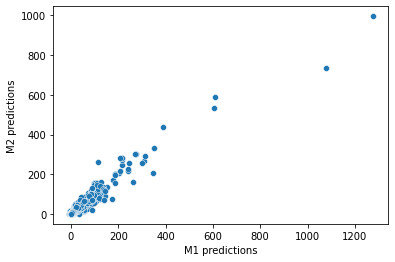

In [18]:
compute_metrics(y_true, m1_d1_predictions, m2_d1_predictions)